In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings


In [2]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.60
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = [0,1,17,2,3,4] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Irrelevant_Balanced'


In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [17]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [7]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        
    elif model_name == "mobilenet":
        # Mobilenet_V2
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, requires_grad=use_pretrained)
        #num_features = model_ft.fc.in_features
        #model_ft.fc = nn.Sequential(
                   # nn.Linear(num_features, 512),
                    #nn.ReLU(),
                    #nn.Linear(512, num_classes)
                    #)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [12]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [13]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 9942 val : 2486 test : 2194


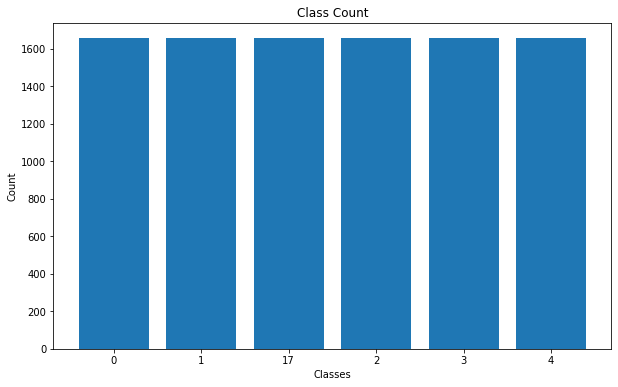

In [15]:
plot_distribution_by_class(trainset, classes)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.conv.weight
	 conv1.bn.weight
	 conv1.bn.bias
	 conv2.conv.weight
	 conv2.bn.weight
	 conv2.bn.bias
	 conv3.conv.weight
	 conv3.bn.weight
	 conv3.bn.bias
	 inception3a.branch1.conv.weight
	 inception3a.branch1.bn.weight
	 inception3a.branch1.bn.bias
	 inception3a.branch2.0.conv.weight
	 inception3a.branch2.0.bn.weight
	 inception3a.branch2.0.bn.bias
	 inception3a.branch2.1.conv.weight
	 inception3a.branch2.1.bn.weight
	 inception3a.branch2.1.bn.bias
	 inception3a.branch3.0.conv.weight
	 inception3a.branch3.0.bn.weight
	 inception3a.branch3.0.bn.bias
	 inception3a.branch3.1.conv.weight
	 inception3a.branch3.1.bn.weight
	 inception3a.branch3.1.bn.bias
	 inception3a.branch4.1.conv.weight
	 inception3a.branch4.1.bn.weight
	 inception3a.branch4.1.bn.bias
	 inception3b.branch1.conv.weight
	 inception3b.branch1.bn.weight
	 inception3b.branch1.bn.bias
	 inception3b.branch2.0.conv.weight
	 inception3b.branch2.0.bn.weight
	 inception3b.branch2.0.bn.bias
	 inception3b.bra

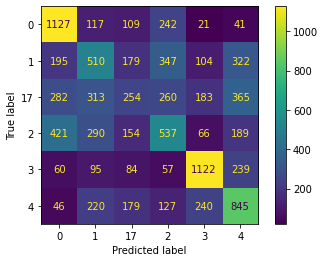

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8037 Acc: 0.5811
val Epoch Entropy: 1.9503
val Balanced Accuracy: 0.1250



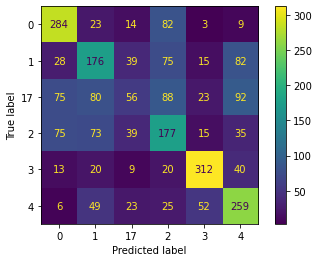

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 1.3123 Acc: 0.4897
train Epoch Entropy: 1.8454
train Balanced Accuracy: 0.7000



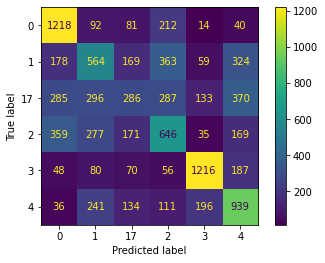

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7394 Acc: 0.5931
val Epoch Entropy: 1.8442
val Balanced Accuracy: 0.2500



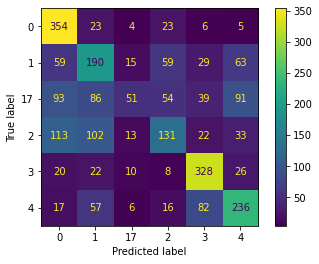

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 1.2821 Acc: 0.4992
train Epoch Entropy: 1.8076
train Balanced Accuracy: 0.7222



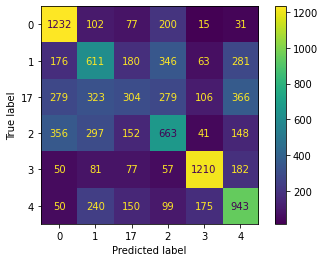

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7747 Acc: 0.5508
val Epoch Entropy: 1.9211
val Balanced Accuracy: 0.6250



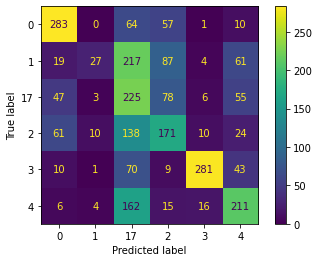

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 1.2563 Acc: 0.5145
train Epoch Entropy: 1.7721
train Balanced Accuracy: 0.3333



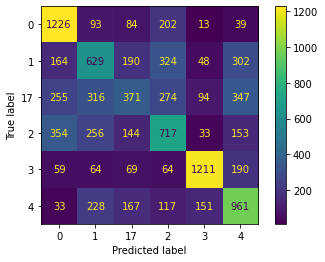

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7814 Acc: 0.6092
val Epoch Entropy: 1.9278
val Balanced Accuracy: 0.5000



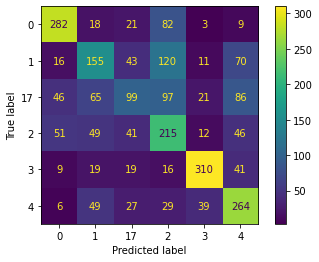

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 1.2398 Acc: 0.5201
train Epoch Entropy: 1.7578
train Balanced Accuracy: 0.6250



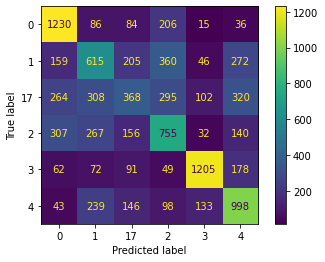

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8124 Acc: 0.6285
val Epoch Entropy: 1.9790
val Balanced Accuracy: 0.7500



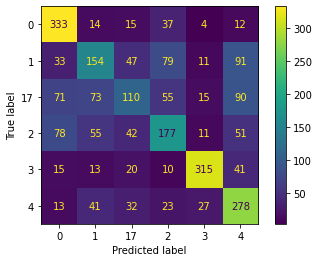

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 1.2304 Acc: 0.5238
train Epoch Entropy: 1.7440
train Balanced Accuracy: 0.8000



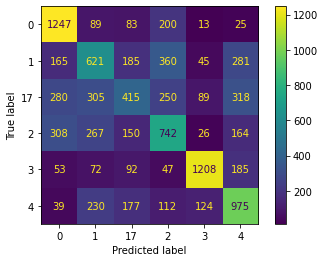

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7506 Acc: 0.5959
val Epoch Entropy: 1.9344
val Balanced Accuracy: 0.8750



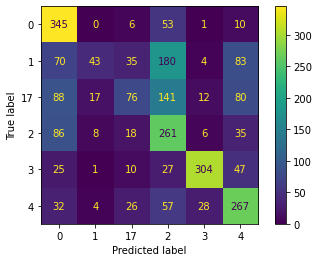

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 1.2099 Acc: 0.5337
train Epoch Entropy: 1.7199
train Balanced Accuracy: 0.5000



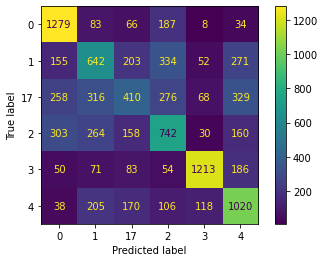

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7418 Acc: 0.6133
val Epoch Entropy: 1.8685
val Balanced Accuracy: 0.6000



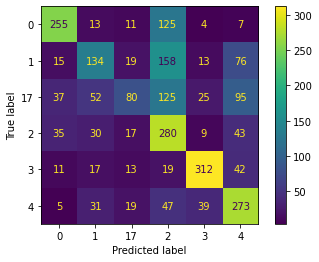

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 1.2070 Acc: 0.5376
train Epoch Entropy: 1.7112
train Balanced Accuracy: 0.3000



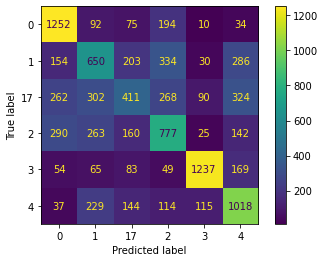

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7970 Acc: 0.6069
val Epoch Entropy: 1.9719
val Balanced Accuracy: 0.5000



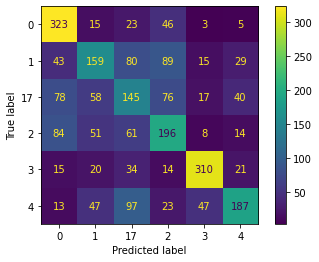

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 1.1506 Acc: 0.5552
train Epoch Entropy: 1.6879
train Balanced Accuracy: 0.5000



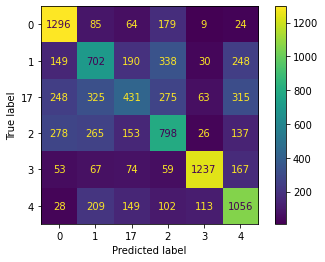

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7366 Acc: 0.6377
val Epoch Entropy: 1.8689
val Balanced Accuracy: 0.7500



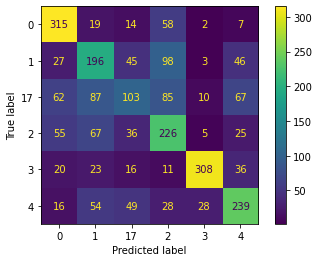

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 1.1316 Acc: 0.5632
train Epoch Entropy: 1.6556
train Balanced Accuracy: 0.8333



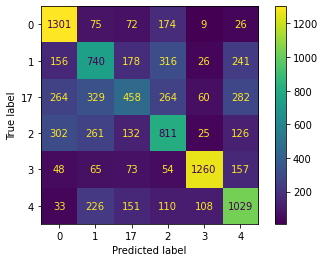

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7181 Acc: 0.6382
val Epoch Entropy: 1.8442
val Balanced Accuracy: 0.7500



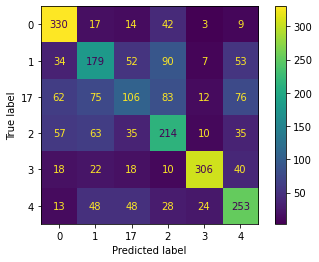

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 1.1301 Acc: 0.5651
train Epoch Entropy: 1.6540
train Balanced Accuracy: 0.7500



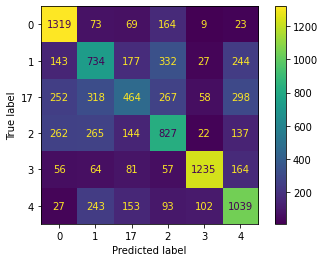

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7181 Acc: 0.6354
val Epoch Entropy: 1.8412
val Balanced Accuracy: 0.4000



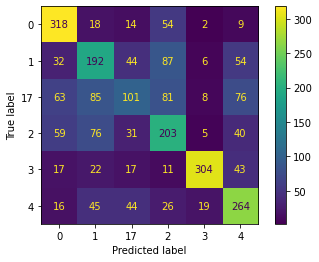

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 1.1291 Acc: 0.5642
train Epoch Entropy: 1.6440
train Balanced Accuracy: 0.5000



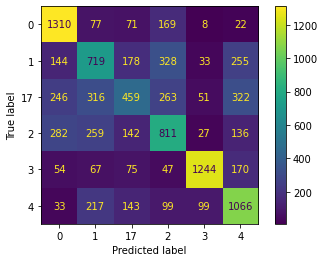

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7120 Acc: 0.6340
val Epoch Entropy: 1.8211
val Balanced Accuracy: 0.5000



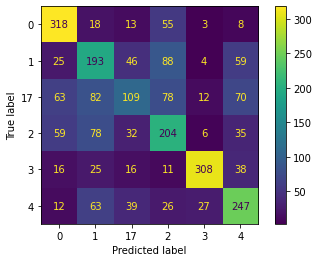

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 1.1284 Acc: 0.5658
train Epoch Entropy: 1.6456
train Balanced Accuracy: 0.5000



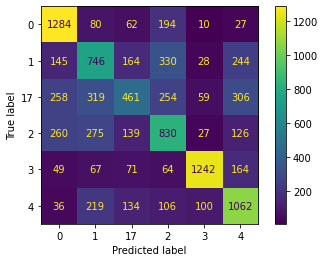

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7118 Acc: 0.6340
val Epoch Entropy: 1.8351
val Balanced Accuracy: 0.3333



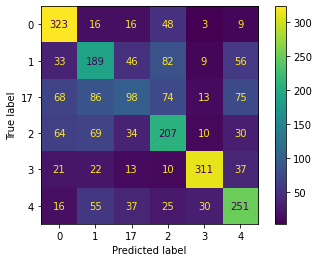

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 1.1282 Acc: 0.5675
train Epoch Entropy: 1.6425
train Balanced Accuracy: 0.3000



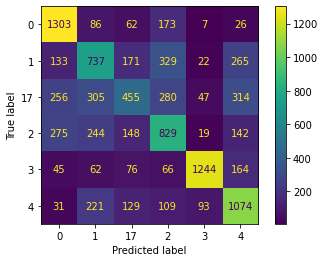

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7128 Acc: 0.6317
val Epoch Entropy: 1.8235
val Balanced Accuracy: 0.2500



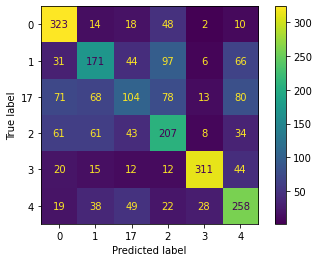

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 1.1206 Acc: 0.5679
train Epoch Entropy: 1.6366
train Balanced Accuracy: 0.5000



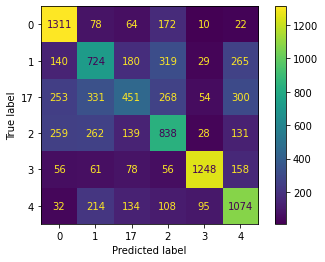

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7055 Acc: 0.6354
val Epoch Entropy: 1.8161
val Balanced Accuracy: 1.0000



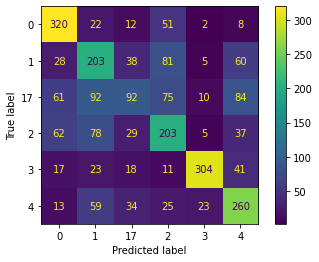

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 1.1216 Acc: 0.5694
train Epoch Entropy: 1.6327
train Balanced Accuracy: 0.7000



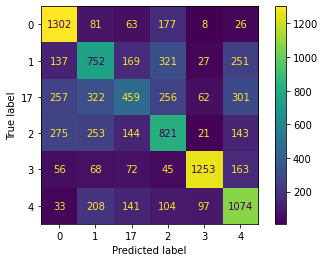

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7154 Acc: 0.6336
val Epoch Entropy: 1.8359
val Balanced Accuracy: 0.2500



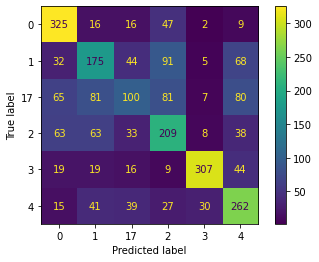

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 1.1233 Acc: 0.5682
train Epoch Entropy: 1.6314
train Balanced Accuracy: 0.5000



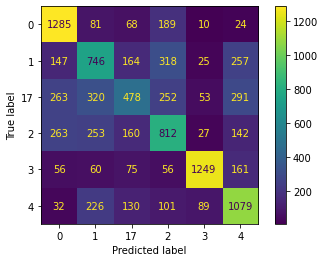

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6988 Acc: 0.6354
val Epoch Entropy: 1.8047
val Balanced Accuracy: 0.3750



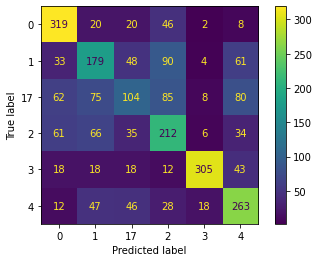

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------

train Loss: 1.1201 Acc: 0.5669
train Epoch Entropy: 1.6297
train Balanced Accuracy: 0.5833



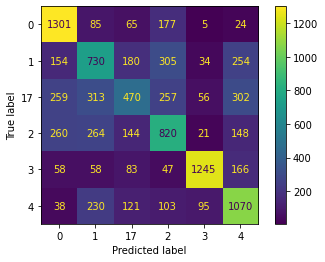

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7051 Acc: 0.6359
val Epoch Entropy: 1.8157
val Balanced Accuracy: 1.0000



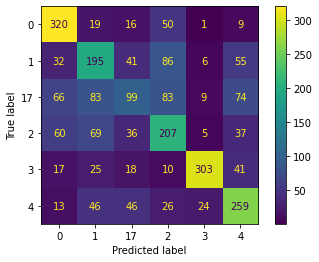

<Figure size 576x432 with 0 Axes>

Epoch 18/59
----------

train Loss: 1.1163 Acc: 0.5716
train Epoch Entropy: 1.6292
train Balanced Accuracy: 0.5000



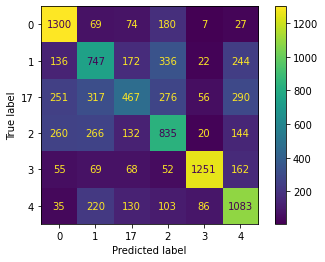

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6953 Acc: 0.6359
val Epoch Entropy: 1.8086
val Balanced Accuracy: 0.5000



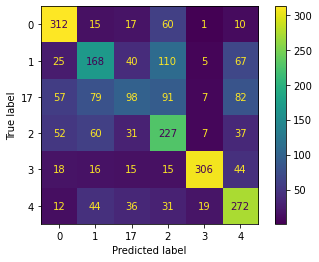

<Figure size 576x432 with 0 Axes>

Epoch 19/59
----------

train Loss: 1.1201 Acc: 0.5655
train Epoch Entropy: 1.6312
train Balanced Accuracy: 0.1667



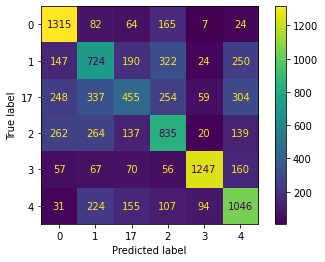

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6941 Acc: 0.6428
val Epoch Entropy: 1.8024
val Balanced Accuracy: 0.3750



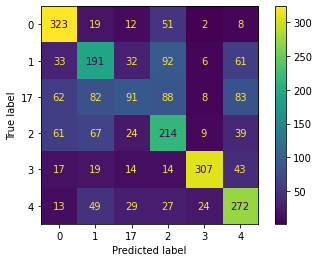

<Figure size 576x432 with 0 Axes>

Epoch 20/59
----------

train Loss: 1.1187 Acc: 0.5645
train Epoch Entropy: 1.6300
train Balanced Accuracy: 0.2500



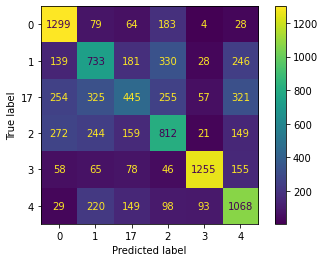

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6935 Acc: 0.6386
val Epoch Entropy: 1.7951
val Balanced Accuracy: 0.5000



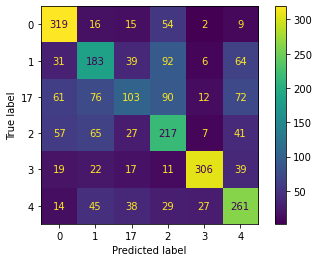

<Figure size 576x432 with 0 Axes>

Epoch 21/59
----------

train Loss: 1.1236 Acc: 0.5696
train Epoch Entropy: 1.6313
train Balanced Accuracy: 0.7222



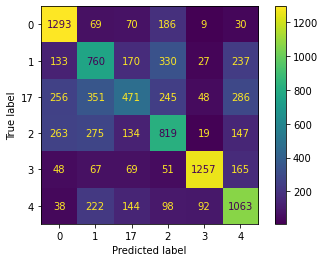

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6985 Acc: 0.6345
val Epoch Entropy: 1.7990
val Balanced Accuracy: 0.4444



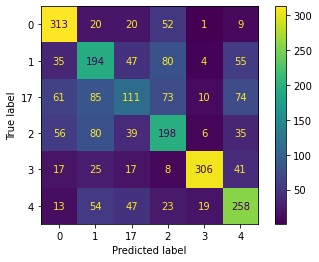

<Figure size 576x432 with 0 Axes>

Epoch 22/59
----------

train Loss: 1.1188 Acc: 0.5664
train Epoch Entropy: 1.6309
train Balanced Accuracy: 0.7000



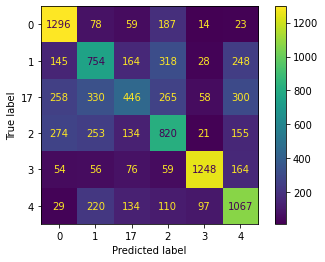

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7025 Acc: 0.6345
val Epoch Entropy: 1.8109
val Balanced Accuracy: 0.3889



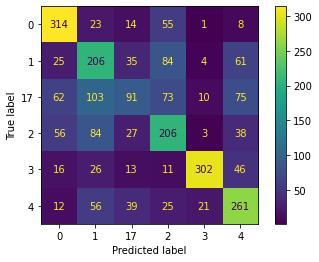

<Figure size 576x432 with 0 Axes>

Epoch 23/59
----------

train Loss: 1.1231 Acc: 0.5665
train Epoch Entropy: 1.6325
train Balanced Accuracy: 0.6667



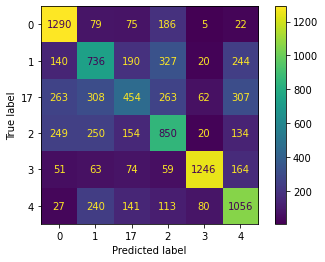

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6896 Acc: 0.6359
val Epoch Entropy: 1.7861
val Balanced Accuracy: 0.3750



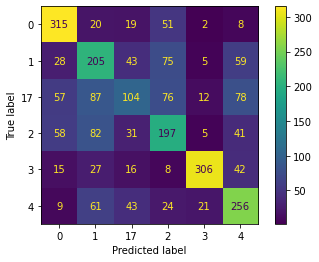

<Figure size 576x432 with 0 Axes>

Epoch 24/59
----------

train Loss: 1.1161 Acc: 0.5680
train Epoch Entropy: 1.6330
train Balanced Accuracy: 0.6000



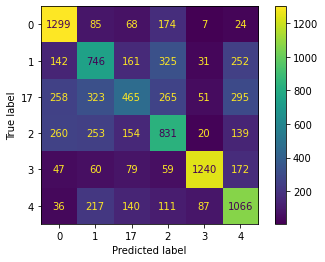

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6902 Acc: 0.6382
val Epoch Entropy: 1.7977
val Balanced Accuracy: 0.6667



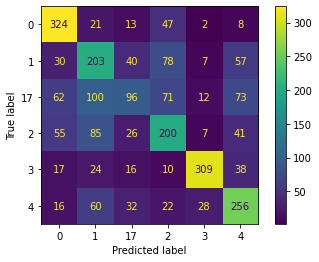

<Figure size 576x432 with 0 Axes>

Epoch 25/59
----------

train Loss: 1.1216 Acc: 0.5700
train Epoch Entropy: 1.6324
train Balanced Accuracy: 0.6000



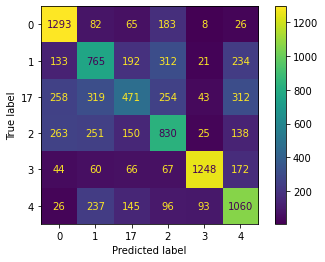

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7133 Acc: 0.6368
val Epoch Entropy: 1.8216
val Balanced Accuracy: 0.3750



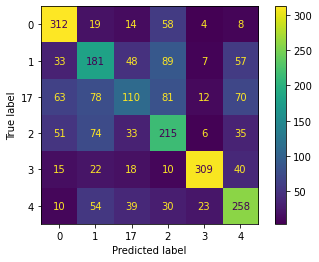

<Figure size 576x432 with 0 Axes>

Epoch 26/59
----------

train Loss: 1.1258 Acc: 0.5641
train Epoch Entropy: 1.6328
train Balanced Accuracy: 0.3333



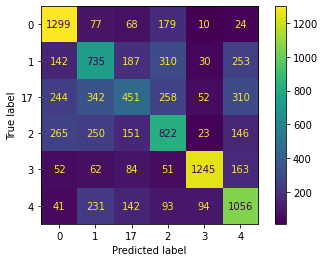

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7154 Acc: 0.6359
val Epoch Entropy: 1.8270
val Balanced Accuracy: 0.7000



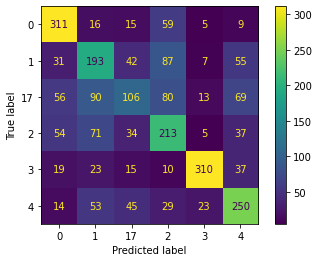

<Figure size 576x432 with 0 Axes>

Epoch 27/59
----------

train Loss: 1.1193 Acc: 0.5711
train Epoch Entropy: 1.6337
train Balanced Accuracy: 0.5833



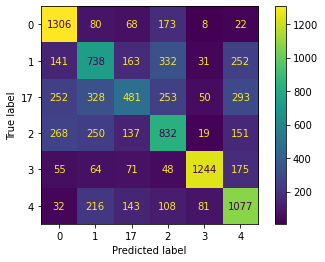

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7069 Acc: 0.6451
val Epoch Entropy: 1.8209
val Balanced Accuracy: 0.5833



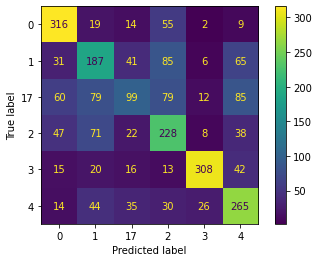

<Figure size 576x432 with 0 Axes>

Epoch 28/59
----------

train Loss: 1.1190 Acc: 0.5693
train Epoch Entropy: 1.6296
train Balanced Accuracy: 0.7500



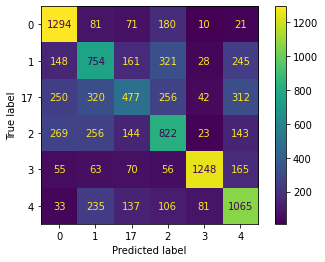

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7056 Acc: 0.6331
val Epoch Entropy: 1.8160
val Balanced Accuracy: 0.4167



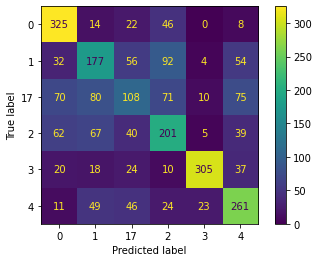

<Figure size 576x432 with 0 Axes>

Epoch 29/59
----------

train Loss: 1.1219 Acc: 0.5651
train Epoch Entropy: 1.6306
train Balanced Accuracy: 0.1250



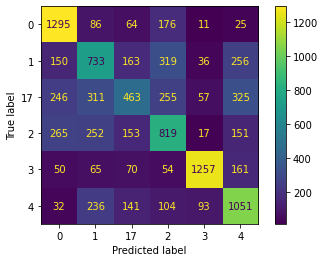

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7018 Acc: 0.6372
val Epoch Entropy: 1.8092
val Balanced Accuracy: 0.5000



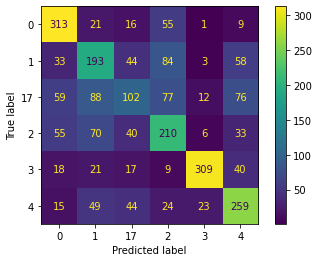

<Figure size 576x432 with 0 Axes>

Epoch 30/59
----------

train Loss: 1.1175 Acc: 0.5695
train Epoch Entropy: 1.6309
train Balanced Accuracy: 0.5000



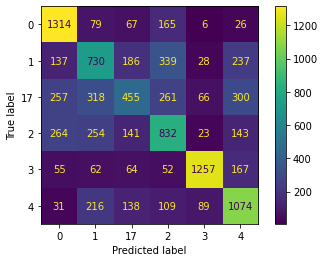

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6931 Acc: 0.6464
val Epoch Entropy: 1.7932
val Balanced Accuracy: 0.8000



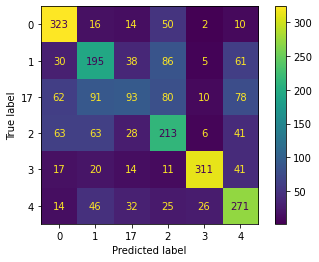

<Figure size 576x432 with 0 Axes>

Epoch 31/59
----------

train Loss: 1.1220 Acc: 0.5699
train Epoch Entropy: 1.6333
train Balanced Accuracy: 0.7500



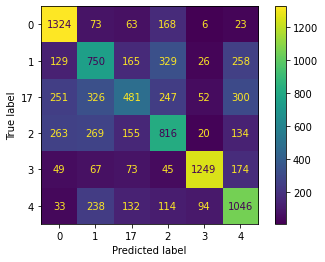

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7034 Acc: 0.6395
val Epoch Entropy: 1.8169
val Balanced Accuracy: 0.8750



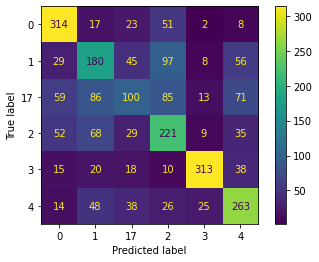

<Figure size 576x432 with 0 Axes>

Epoch 32/59
----------

train Loss: 1.1260 Acc: 0.5648
train Epoch Entropy: 1.6279
train Balanced Accuracy: 0.3889



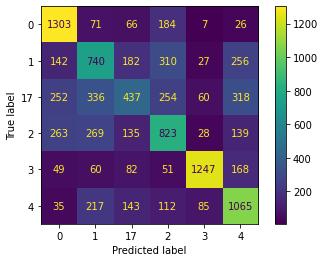

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7036 Acc: 0.6423
val Epoch Entropy: 1.8108
val Balanced Accuracy: 0.5000



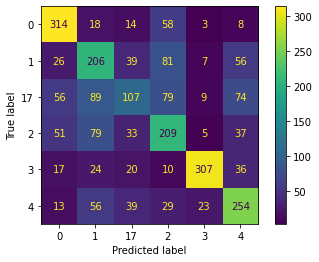

<Figure size 576x432 with 0 Axes>

Epoch 33/59
----------

train Loss: 1.1155 Acc: 0.5738
train Epoch Entropy: 1.6298
train Balanced Accuracy: 0.6667



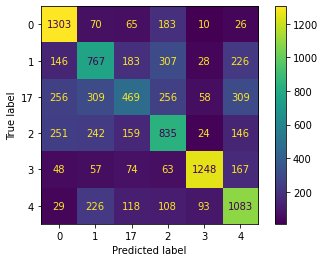

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7167 Acc: 0.6386
val Epoch Entropy: 1.8291
val Balanced Accuracy: 0.6250



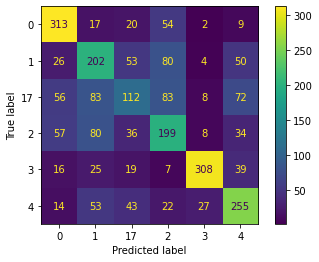

<Figure size 576x432 with 0 Axes>

Epoch 34/59
----------

train Loss: 1.1236 Acc: 0.5673
train Epoch Entropy: 1.6288
train Balanced Accuracy: 0.2500



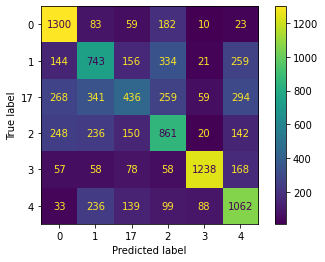

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6957 Acc: 0.6377
val Epoch Entropy: 1.8028
val Balanced Accuracy: 0.6250



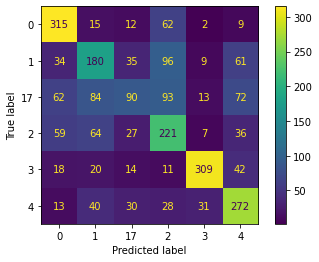

<Figure size 576x432 with 0 Axes>

Epoch 35/59
----------

train Loss: 1.1200 Acc: 0.5703
train Epoch Entropy: 1.6292
train Balanced Accuracy: 0.5556



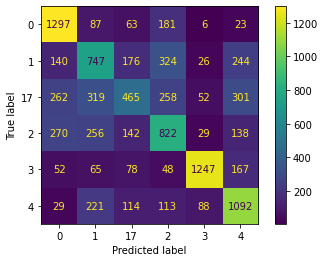

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7010 Acc: 0.6395
val Epoch Entropy: 1.8076
val Balanced Accuracy: 0.5000



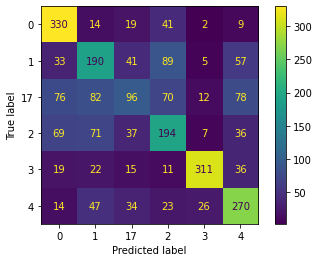

<Figure size 576x432 with 0 Axes>

Epoch 36/59
----------

train Loss: 1.1228 Acc: 0.5680
train Epoch Entropy: 1.6310
train Balanced Accuracy: 0.5000



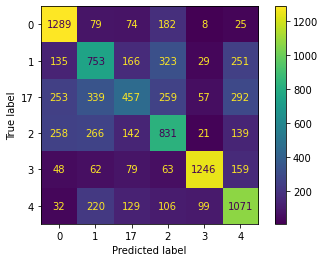

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7014 Acc: 0.6363
val Epoch Entropy: 1.8084
val Balanced Accuracy: 0.5000



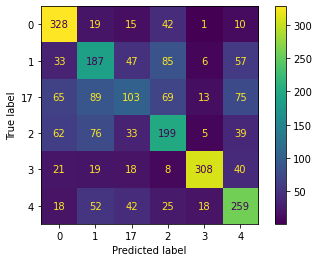

<Figure size 576x432 with 0 Axes>

Epoch 37/59
----------

train Loss: 1.1187 Acc: 0.5690
train Epoch Entropy: 1.6286
train Balanced Accuracy: 0.5000



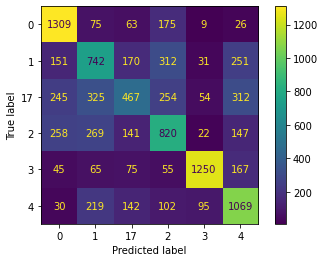

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6869 Acc: 0.6414
val Epoch Entropy: 1.7868
val Balanced Accuracy: 0.2000



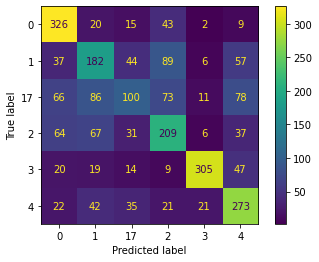

<Figure size 576x432 with 0 Axes>

Epoch 38/59
----------

train Loss: 1.1203 Acc: 0.5680
train Epoch Entropy: 1.6318
train Balanced Accuracy: 0.4000



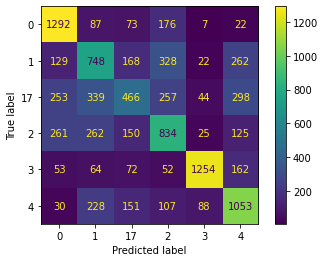

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7065 Acc: 0.6405
val Epoch Entropy: 1.8190
val Balanced Accuracy: 0.6250



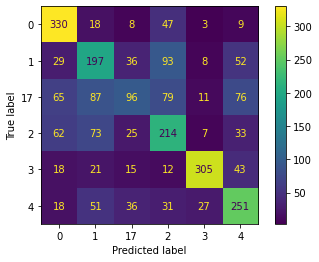

<Figure size 576x432 with 0 Axes>

Epoch 39/59
----------

train Loss: 1.1204 Acc: 0.5675
train Epoch Entropy: 1.6307
train Balanced Accuracy: 0.6667



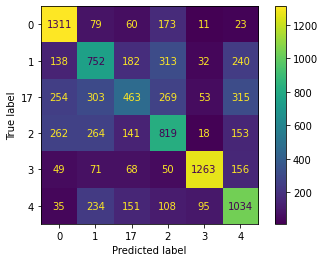

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6997 Acc: 0.6474
val Epoch Entropy: 1.8066
val Balanced Accuracy: 0.1250



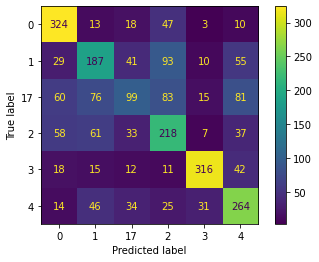

<Figure size 576x432 with 0 Axes>

Epoch 40/59
----------

train Loss: 1.1220 Acc: 0.5697
train Epoch Entropy: 1.6326
train Balanced Accuracy: 0.5000



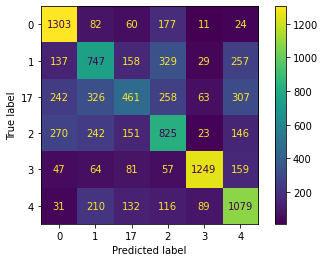

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6869 Acc: 0.6414
val Epoch Entropy: 1.7828
val Balanced Accuracy: 0.7500



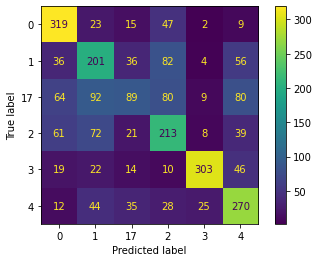

<Figure size 576x432 with 0 Axes>

Epoch 41/59
----------

train Loss: 1.1238 Acc: 0.5646
train Epoch Entropy: 1.6327
train Balanced Accuracy: 0.6250



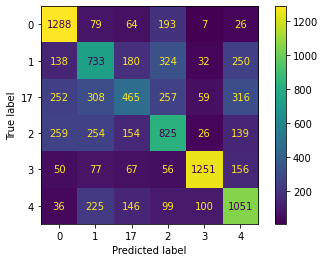

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7064 Acc: 0.6418
val Epoch Entropy: 1.8226
val Balanced Accuracy: 0.5000



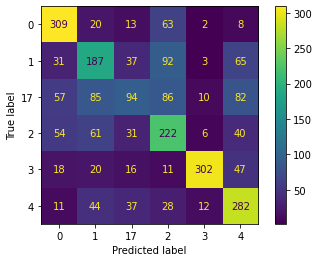

<Figure size 576x432 with 0 Axes>

Epoch 42/59
----------

train Loss: 1.1191 Acc: 0.5684
train Epoch Entropy: 1.6294
train Balanced Accuracy: 0.6667



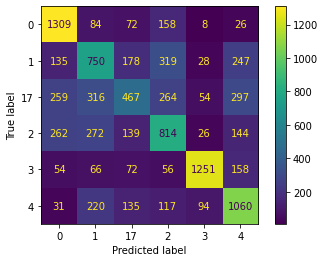

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6913 Acc: 0.6308
val Epoch Entropy: 1.7874
val Balanced Accuracy: 0.6000



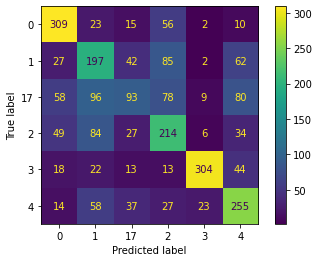

<Figure size 576x432 with 0 Axes>

Epoch 43/59
----------

train Loss: 1.1215 Acc: 0.5668
train Epoch Entropy: 1.6275
train Balanced Accuracy: 0.6250



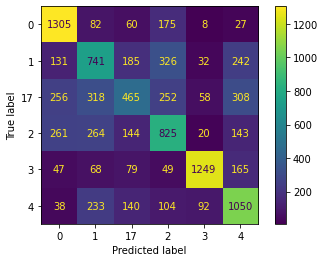

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7025 Acc: 0.6428
val Epoch Entropy: 1.8148
val Balanced Accuracy: 0.3750



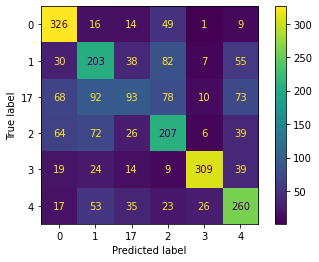

<Figure size 576x432 with 0 Axes>

Epoch 44/59
----------

train Loss: 1.1167 Acc: 0.5711
train Epoch Entropy: 1.6296
train Balanced Accuracy: 0.7778



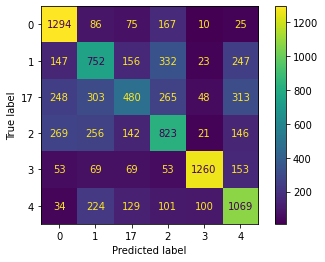

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6901 Acc: 0.6368
val Epoch Entropy: 1.7884
val Balanced Accuracy: 0.4000



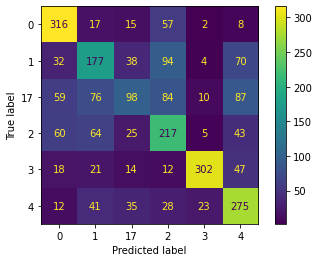

<Figure size 576x432 with 0 Axes>

Epoch 45/59
----------

train Loss: 1.1199 Acc: 0.5681
train Epoch Entropy: 1.6322
train Balanced Accuracy: 0.6667



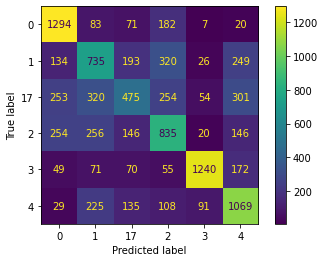

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7153 Acc: 0.6377
val Epoch Entropy: 1.8340
val Balanced Accuracy: 0.8333



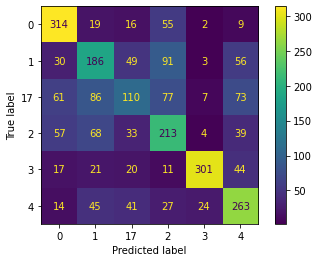

<Figure size 576x432 with 0 Axes>

Epoch 46/59
----------

train Loss: 1.1173 Acc: 0.5682
train Epoch Entropy: 1.6311
train Balanced Accuracy: 0.3750



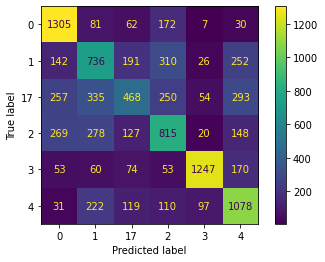

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7026 Acc: 0.6492
val Epoch Entropy: 1.8167
val Balanced Accuracy: 0.1111



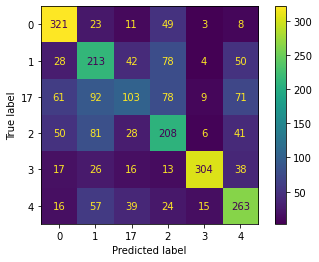

<Figure size 576x432 with 0 Axes>

Epoch 47/59
----------

train Loss: 1.1180 Acc: 0.5733
train Epoch Entropy: 1.6291
train Balanced Accuracy: 0.7222



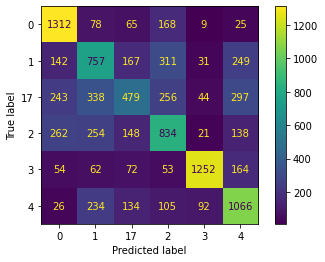

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6921 Acc: 0.6400
val Epoch Entropy: 1.7911
val Balanced Accuracy: 0.4000



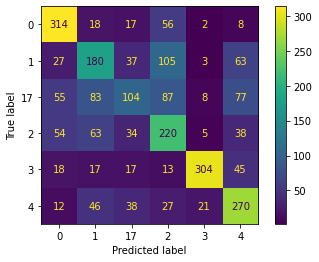

<Figure size 576x432 with 0 Axes>

Epoch 48/59
----------

train Loss: 1.1230 Acc: 0.5673
train Epoch Entropy: 1.6293
train Balanced Accuracy: 0.4444



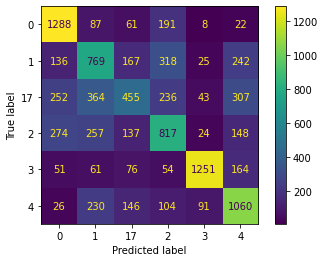

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6969 Acc: 0.6359
val Epoch Entropy: 1.8081
val Balanced Accuracy: 0.7500



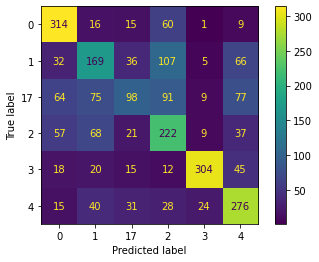

<Figure size 576x432 with 0 Axes>

Epoch 49/59
----------

train Loss: 1.1201 Acc: 0.5665
train Epoch Entropy: 1.6289
train Balanced Accuracy: 0.3750



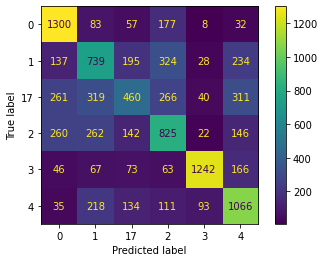

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7030 Acc: 0.6446
val Epoch Entropy: 1.8201
val Balanced Accuracy: 0.5833



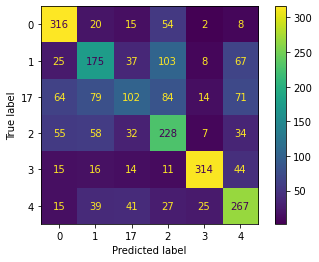

<Figure size 576x432 with 0 Axes>

Epoch 50/59
----------

train Loss: 1.1211 Acc: 0.5671
train Epoch Entropy: 1.6285
train Balanced Accuracy: 0.9000



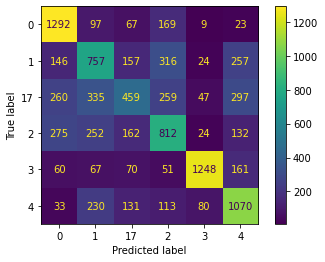

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7030 Acc: 0.6400
val Epoch Entropy: 1.8136
val Balanced Accuracy: 0.5000



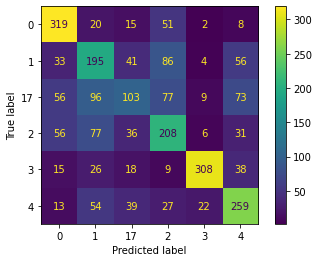

<Figure size 576x432 with 0 Axes>

Epoch 51/59
----------

train Loss: 1.1250 Acc: 0.5706
train Epoch Entropy: 1.6284
train Balanced Accuracy: 0.6667



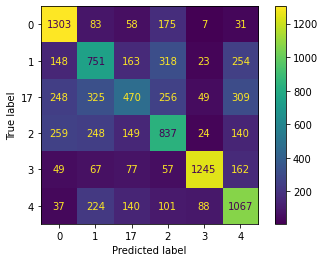

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7120 Acc: 0.6428
val Epoch Entropy: 1.8312
val Balanced Accuracy: 0.5833



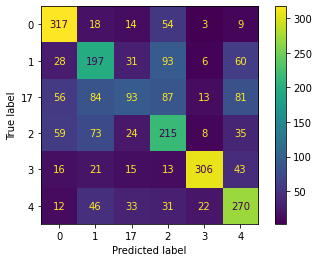

<Figure size 576x432 with 0 Axes>

Epoch 52/59
----------

train Loss: 1.1156 Acc: 0.5689
train Epoch Entropy: 1.6296
train Balanced Accuracy: 0.6667



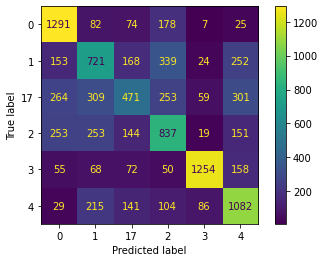

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7189 Acc: 0.6400
val Epoch Entropy: 1.8391
val Balanced Accuracy: 0.5000



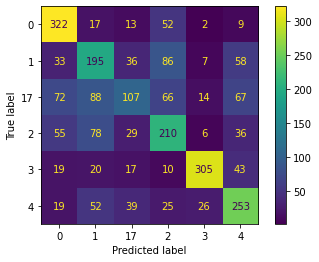

<Figure size 576x432 with 0 Axes>

Epoch 53/59
----------

train Loss: 1.1254 Acc: 0.5678
train Epoch Entropy: 1.6342
train Balanced Accuracy: 0.2000



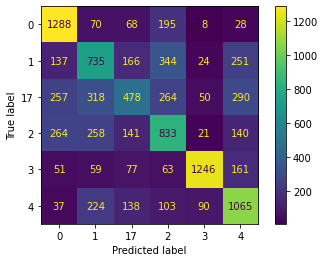

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7119 Acc: 0.6354
val Epoch Entropy: 1.8238
val Balanced Accuracy: 0.5000



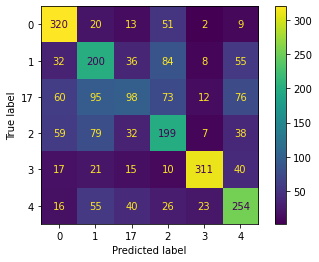

<Figure size 576x432 with 0 Axes>

Epoch 54/59
----------

train Loss: 1.1235 Acc: 0.5639
train Epoch Entropy: 1.6297
train Balanced Accuracy: 0.8000



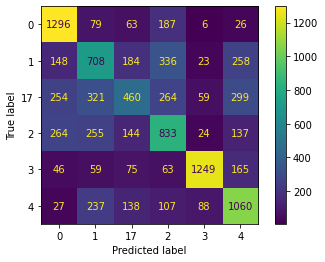

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7102 Acc: 0.6294
val Epoch Entropy: 1.8198
val Balanced Accuracy: 0.5833



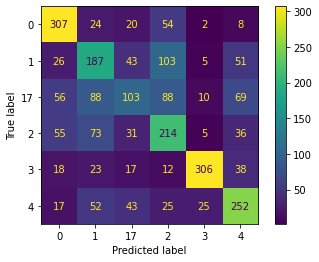

<Figure size 576x432 with 0 Axes>

Epoch 55/59
----------

train Loss: 1.1231 Acc: 0.5701
train Epoch Entropy: 1.6334
train Balanced Accuracy: 0.6000



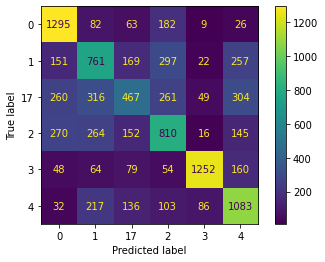

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6985 Acc: 0.6368
val Epoch Entropy: 1.8001
val Balanced Accuracy: 0.6250



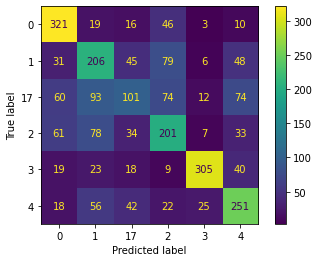

<Figure size 576x432 with 0 Axes>

Epoch 56/59
----------

train Loss: 1.1151 Acc: 0.5722
train Epoch Entropy: 1.6299
train Balanced Accuracy: 0.6250



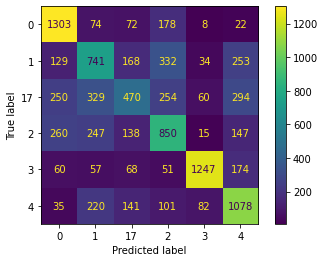

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.7125 Acc: 0.6354
val Epoch Entropy: 1.8258
val Balanced Accuracy: 0.2500



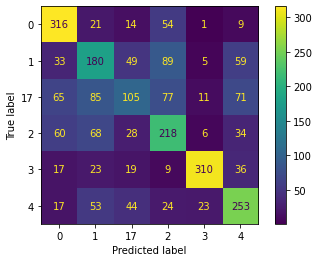

<Figure size 576x432 with 0 Axes>

Epoch 57/59
----------

train Loss: 1.1204 Acc: 0.5675
train Epoch Entropy: 1.6310
train Balanced Accuracy: 0.8750



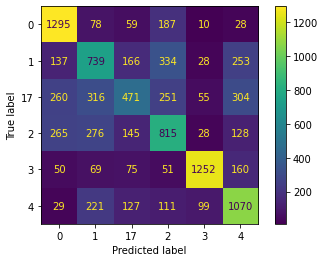

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6919 Acc: 0.6441
val Epoch Entropy: 1.7995
val Balanced Accuracy: 0.5000



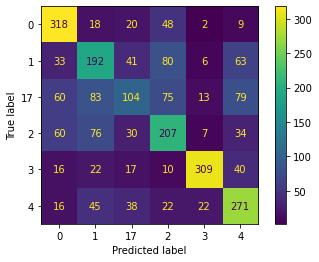

<Figure size 576x432 with 0 Axes>

Epoch 58/59
----------

train Loss: 1.1177 Acc: 0.5683
train Epoch Entropy: 1.6353
train Balanced Accuracy: 1.0000



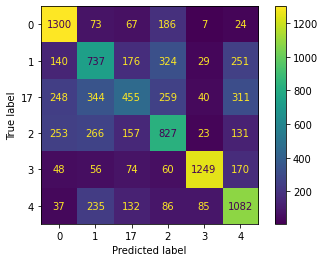

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6994 Acc: 0.6432
val Epoch Entropy: 1.8092
val Balanced Accuracy: 0.7500



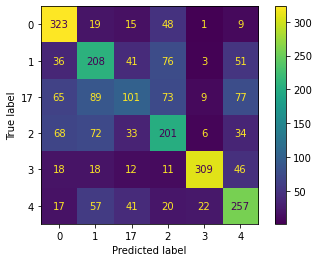

<Figure size 576x432 with 0 Axes>

Epoch 59/59
----------

train Loss: 1.1262 Acc: 0.5655
train Epoch Entropy: 1.6307
train Balanced Accuracy: 0.7500



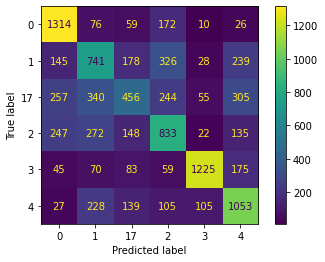

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.6902 Acc: 0.6464
val Epoch Entropy: 1.7940
val Balanced Accuracy: 0.5000



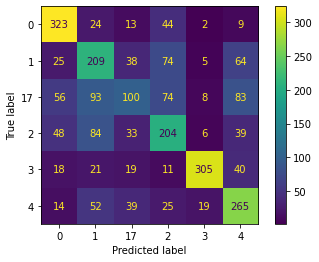

<Figure size 576x432 with 0 Axes>

Training complete in 126m 33s
Best val Acc: 0.649195
Best Val Acc. was achieved at epoch 46


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.

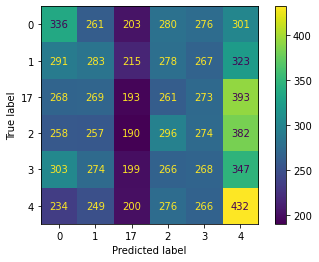

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 1.7957 Acc: 0.1903
val Epoch Entropy: 2.9269
val Balanced Accuracy: 0.0000



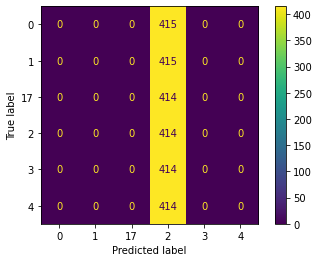

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 1.6038 Acc: 0.3243
train Epoch Entropy: 2.1557
train Balanced Accuracy: 0.2000



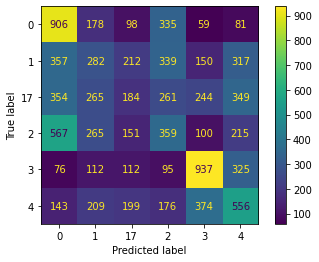

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 1.1467 Acc: 0.4207
val Epoch Entropy: 2.3369
val Balanced Accuracy: 0.4000



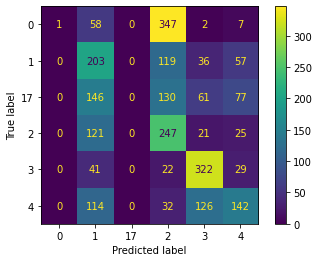

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 1.4189 Acc: 0.4194
train Epoch Entropy: 1.9721
train Balanced Accuracy: 0.6667



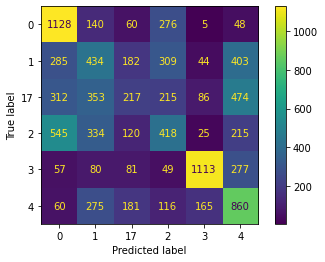

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 1.0195 Acc: 0.5274
val Epoch Entropy: 2.2243
val Balanced Accuracy: 0.7500



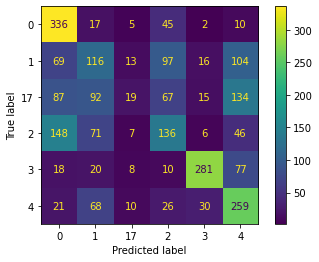

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 1.3720 Acc: 0.4455
train Epoch Entropy: 1.9175
train Balanced Accuracy: 0.4000



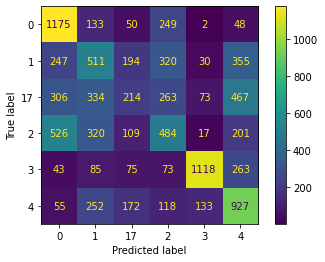

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 1.0684 Acc: 0.5384
val Epoch Entropy: 2.2829
val Balanced Accuracy: 0.4167



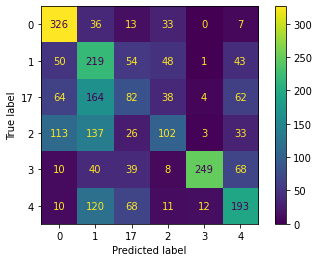

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 1.4236 Acc: 0.4187
train Epoch Entropy: 1.9520
train Balanced Accuracy: 0.6250



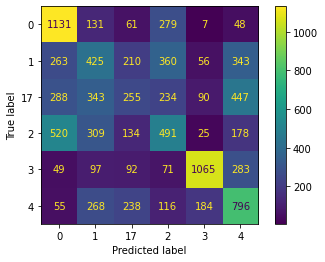

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.9444 Acc: 0.5421
val Epoch Entropy: 2.1899
val Balanced Accuracy: 0.6250



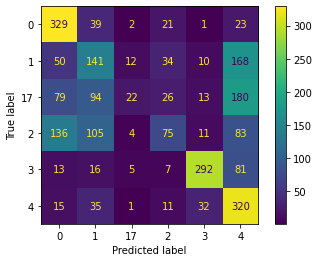

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 1.3549 Acc: 0.4635
train Epoch Entropy: 1.8909
train Balanced Accuracy: 0.9000



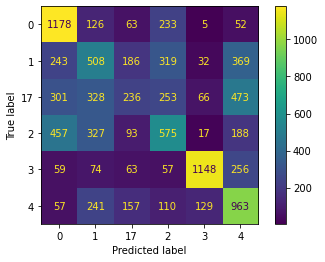

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.9396 Acc: 0.5669
val Epoch Entropy: 2.1796
val Balanced Accuracy: 0.5833



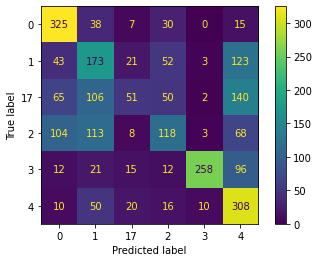

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 1.3330 Acc: 0.4665
train Epoch Entropy: 1.8528
train Balanced Accuracy: 0.5000



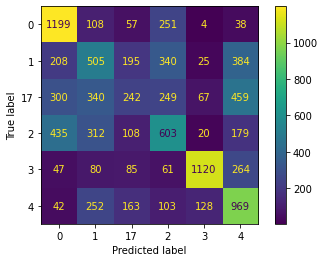

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.9990 Acc: 0.5536
val Epoch Entropy: 2.2206
val Balanced Accuracy: 0.5000



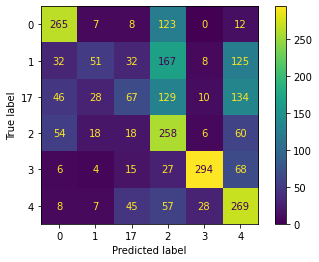

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 1.3234 Acc: 0.4807
train Epoch Entropy: 1.8503
train Balanced Accuracy: 0.6667



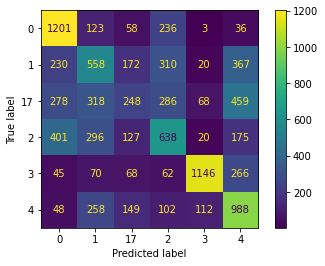

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.9255 Acc: 0.5789
val Epoch Entropy: 2.1792
val Balanced Accuracy: 0.5000



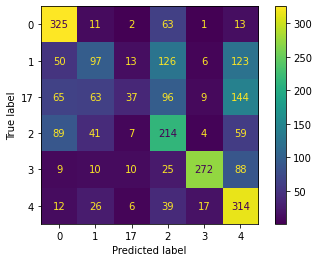

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 1.3068 Acc: 0.4889
train Epoch Entropy: 1.8190
train Balanced Accuracy: 0.6667



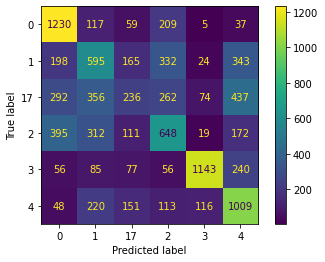

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.9476 Acc: 0.5724
val Epoch Entropy: 2.1722
val Balanced Accuracy: 0.3750



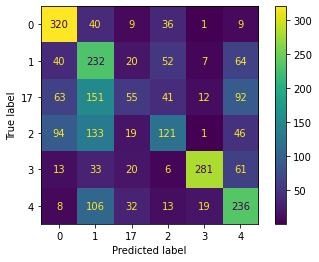

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 1.2765 Acc: 0.4978
train Epoch Entropy: 1.8266
train Balanced Accuracy: 0.6250



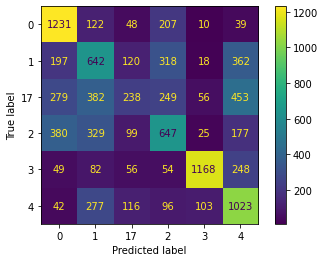

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8938 Acc: 0.5963
val Epoch Entropy: 2.1001
val Balanced Accuracy: 0.2500



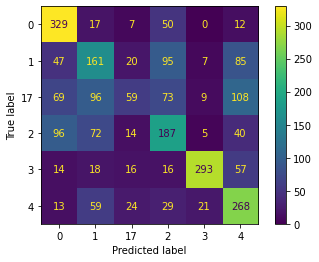

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 1.2461 Acc: 0.5144
train Epoch Entropy: 1.7920
train Balanced Accuracy: 0.8333



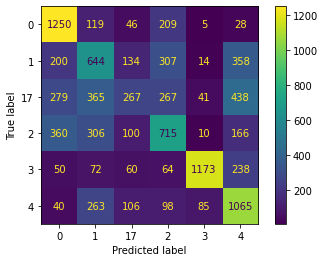

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8658 Acc: 0.6014
val Epoch Entropy: 2.0590
val Balanced Accuracy: 0.7000



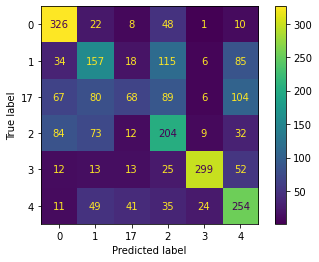

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 1.2398 Acc: 0.5151
train Epoch Entropy: 1.7786
train Balanced Accuracy: 0.6000



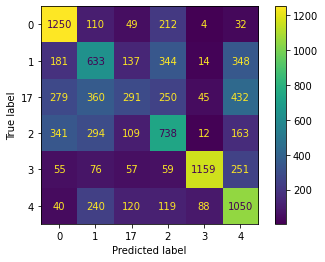

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8512 Acc: 0.6069
val Epoch Entropy: 2.0553
val Balanced Accuracy: 0.3333



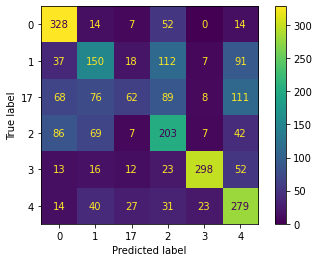

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 1.2298 Acc: 0.5149
train Epoch Entropy: 1.7621
train Balanced Accuracy: 0.5000



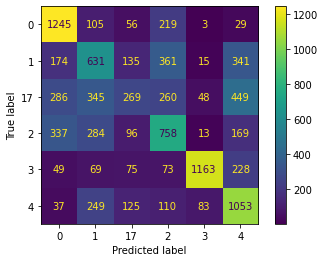

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8798 Acc: 0.6051
val Epoch Entropy: 2.0991
val Balanced Accuracy: 1.0000



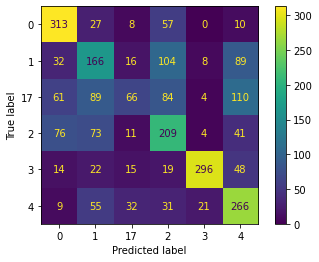

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 1.2292 Acc: 0.5214
train Epoch Entropy: 1.7692
train Balanced Accuracy: 0.5000



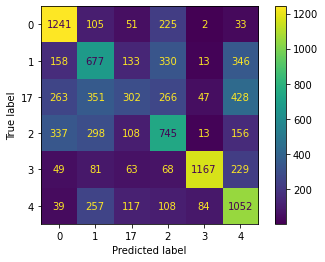

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8342 Acc: 0.6023
val Epoch Entropy: 2.0329
val Balanced Accuracy: 0.5000



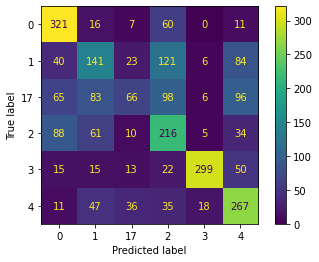

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 1.2222 Acc: 0.5205
train Epoch Entropy: 1.7508
train Balanced Accuracy: 0.5833



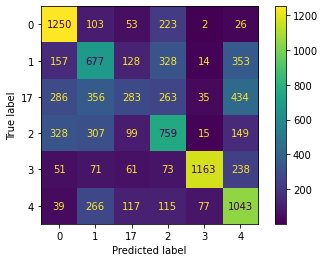

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8507 Acc: 0.6078
val Epoch Entropy: 2.0367
val Balanced Accuracy: 0.5000



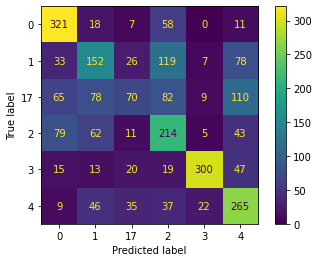

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 1.2158 Acc: 0.5208
train Epoch Entropy: 1.7522
train Balanced Accuracy: 0.5833



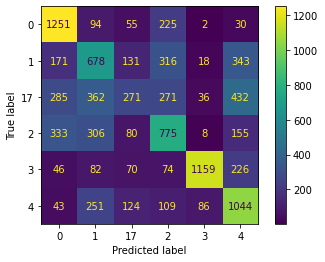

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8520 Acc: 0.6207
val Epoch Entropy: 2.0362
val Balanced Accuracy: 0.4000



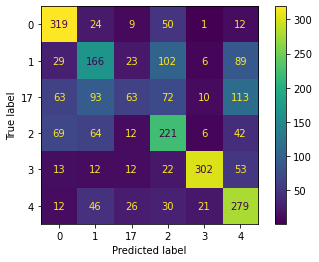

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 1.2185 Acc: 0.5210
train Epoch Entropy: 1.7431
train Balanced Accuracy: 0.3750



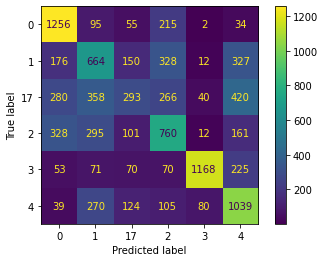

<Figure size 576x432 with 0 Axes>

Number of skipped: 311

val Loss: 0.8339 Acc: 0.6087
val Epoch Entropy: 2.0378
val Balanced Accuracy: 0.5556



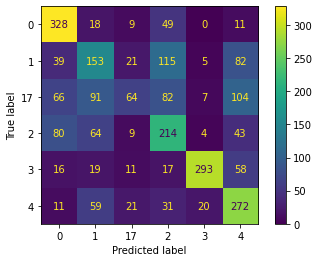

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------


KeyboardInterrupt: 

In [25]:
model_list = []

for model_name in ["googlenet","vgg"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    
    model_list.append(model)



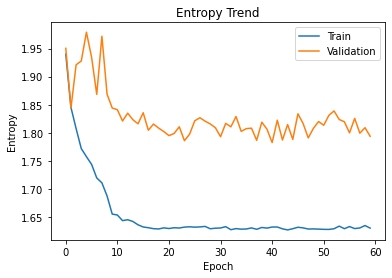

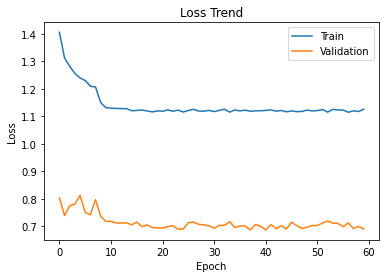

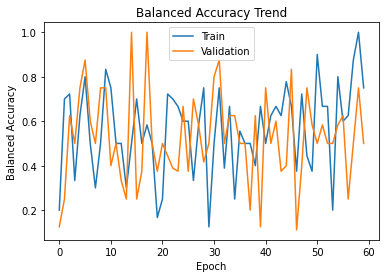

In [26]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

The Test Accuracy: tensor(0.6472, device='cuda:0')
The Test Balanced Accuracy: 0.566167627317414
Skipped Inputs: 275


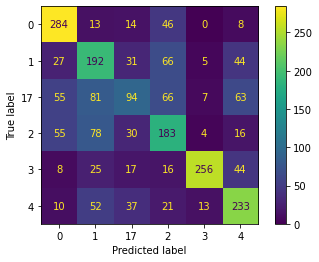

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6498, device='cuda:0')
The Test Balanced Accuracy: 0.5684395039548868
Skipped Inputs: 275


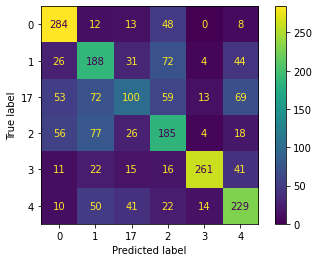

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6436, device='cuda:0')
The Test Balanced Accuracy: 0.562966289891958
Skipped Inputs: 275


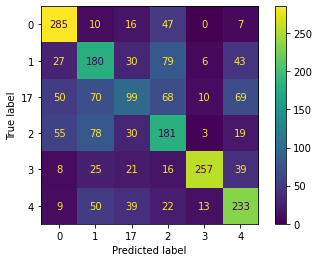

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6441, device='cuda:0')
The Test Balanced Accuracy: 0.5634241584948974
Skipped Inputs: 275


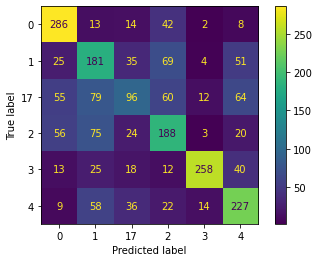

<Figure size 576x432 with 0 Axes>

The Test Accuracy: tensor(0.6555, device='cuda:0')
The Test Balanced Accuracy: 0.5734498590213839
Skipped Inputs: 275


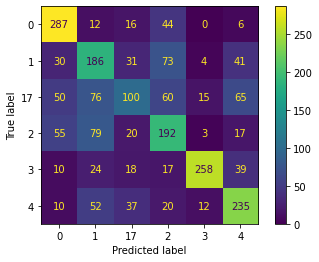

<Figure size 576x432 with 0 Axes>

In [27]:
for model in model_list:
    for hardness_threshold in [30,35,40,60,75]:
        test_model(model, testset, hardness_threshold)


In [28]:
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

In [29]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.15496809480401094


Accuracy for SVM: 0.5615314494074749
Balanced Accuracy:0.5615764653042892


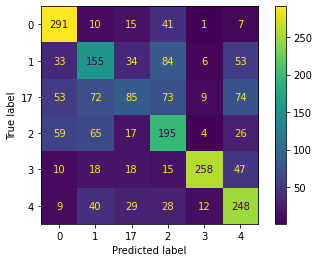

<Figure size 576x432 with 0 Axes>

In [30]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.545123062898815
Balanced Accuracy:0.5451443471317713


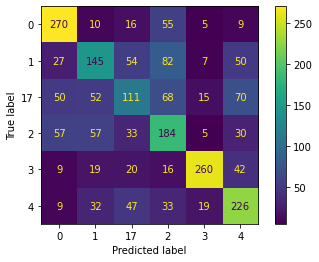

<Figure size 576x432 with 0 Axes>

In [31]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()